importing packages

In [ ]:
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatwCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import Flatw0waCDM
import scipy
from escape_functions_noastropy import *
from multiprocessing import Process
from multiprocessing import Queue
from multiprocessing import Pool
import emcee
import corner

# from multiprocessing import cpu_count
# ncpu = cpu_count()
# print("{0} CPUs".format(ncpu))

initializing cosmology

In [3]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

creating fake data: true values, then adding error

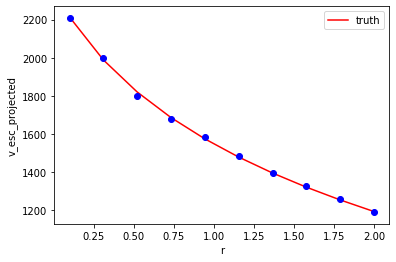

In [44]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2, name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)

z = 0.2
radial_bins = 10
y_err = 10
N = 100

Omega_M = 0.2
little_h = 0.7

M200 = 5e14*u.solMass
# M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200_orig, 0.2, z,cosmo_params, cosmo.name)

radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = theta_data_array = radius_array / D_A(z, cosmo_params, cosmo.name).value

ydata_err = np.repeat(y_err, len(ydata))

r, truth = v_esc_NFW_M200(theta_data_array,z,M200.value,N,cosmo_params, cosmo.name)
ydata = truth + np.random.normal(0,y_err,size=radial_bins) 

plt.plot(r, truth, "r", label = 'truth')
plt.errorbar(r, ydata, yerr=ydata_err, fmt = "bo")
plt.ylabel("v_esc_projected")
plt.xlabel("r")
plt.legend()
plt.show()

fitting M200 to v_esc_NFW_M200

In [46]:
def lnprior(theta):
    p_M200 = theta[0]
    
    if not(1e13 < p_M200 < 1e17):
          return -np.inf
        
    return 0.0


def lnlike(theta, x, y, yerr): 
    p_M200 = theta[0]
    p_theta_array = x
    
    ymodel = v_esc_NFW_M200(p_theta_array, z, p_M200, N, cosmo_params, 'FlatLambdaCDM')

    inv_sigma2 = 1.0/(ydata_err**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

# lnprob([5e13], xdata, ydata, ydata_err)

-185765.7380385856

In [ ]:
ndim, nwalkers, nsteps = 1, 50, 1000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13])#print np.shape(p0)

pool = Pool(processes=20)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

burn = 100
samples = sampler.chain[:, burn:, :].reshape((-1, 1))
print np.shape(sampler.chain)
fig = corner.corner(samples[:,:], labels=["M200"], truths = [M200.value])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print 'median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33
print 'median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33)
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print 'Truth: ', np.log10(M200.value)